In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install git+https://github.com/Greg-hub-dev/anapath.git

In [ ]:
!pip install accelerate datasets evaluate transformers peft scikit-learn torch torchvision evaluate --quiet

In [1]:
from pathlib import Path
import os

# Set your working directory and cache directory which
# will contain datasets and models
working_directory = Path("/kaggle/input/anapath/anapath/Dataset")
testing_directory = Path("/kaggle/input/anapath-new/new")
files = os.listdir(working_directory)
files_test = os.listdir(testing_directory)

files, files_test

(['label_tumor4.csv', 'train'], ['tumor', 'normal'])

In [2]:
import os
from typing import Optional
import random
import numpy as np
import torch
from datasets import load_dataset

from datasets import load_dataset
from transformers import set_seed as set_seed_hf
from transformers import AutoImageProcessor

dataset_name = "breast"
model_name = "owkin/phikon-v2" # or "owkin/phikon-v2"
# You can change the dataset name above if you wish to finetune the model on your own dataset.


# We set a seed globally for data loading and training
SEED = 123

def set_seed(seed: Optional[int] = None):
    """Set all seeds to make results reproducible (deterministic mode).
    When seed is None, disables deterministic mode.
    Credits @BramVanroy
    """
    if seed is not None:
        set_seed_hf(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)


dataset = load_dataset(
    path=f"{working_directory}/train",
    split="train"
)
dataset_test = load_dataset(
    path=f"{testing_directory}",
    split="train"
)

#train_dataset = load_dataset(
#    path=f"{data_dir}/train",
#    split=None
#)
#val_dataset = load_dataset(
#     path=f"{data_dir}/val",
#    split=None
#)
#test_dataset = load_dataset(
#    path=f"{data_dir}/test",
#    split=None
#)
# From the NCT-CRC 999 samples, we create train and validation sets
# of 500 and 499 images, respectively
dataset_splits = dataset.train_test_split(
    test_size=(150 / 957),
    shuffle=True,
    seed=SEED
)
train_dataset = dataset_splits["train"]
val_dataset = dataset_splits["test"]
test_dataset = dataset_test

# Test dataset contains 7,180 images
#data_dir = "/content/drive/MyDrive/anapath/anapath/Dataset"
#test_dataset = load_dataset(
#    dataset_name,
#    data_dir=data_dir
#)
print(
    f"Training dataset size: {len(train_dataset)}\n"
    f"Validation dataset size: {len(val_dataset)}\n"
    f"Test dataset size: {len(test_dataset)}\n"
)

Resolving data files:   0%|          | 0/959 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Resolving data files:   0%|          | 0/139 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Training dataset size: 807
Validation dataset size: 150
Test dataset size: 139



In [10]:
image_processor = AutoImageProcessor.from_pretrained("owkin/phikon-v2")
image_size = image_processor.crop_size if "v2" in model_name else image_processor.size
print(image_processor)

preprocessor_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [11]:
from typing import Any
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    Lambda,
    ToTensor,
)

# ImageNet normalization
normalize = Normalize(
    mean=image_processor.image_mean,
    std=image_processor.image_std
)

# train transforms = random crop, resizing to 224x224, random flip, normalization
train_transforms = Compose(
    [
        RandomResizedCrop(image_size["height"]),
        RandomHorizontalFlip(),
        #RandomVerticalFlip(),
        ToTensor(),
        Lambda(lambda image: image[:3, :, :]), 
        normalize,
    ]
)

# val transforms = resizing to 224x224, normalization
val_transforms = Compose(
    [
        Resize(image_size["height"]),
        CenterCrop(image_size["height"]),
        ToTensor(),
        Lambda(lambda image: image[:3, :, :]),  # Select first 3 channels (RGB)
        normalize,
    ]
)


def preprocess_train(example_batch: dict[str, Any]) -> dict[str, Any]:
    """Apply ``train_transforms`` across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image) for image in example_batch["image"]
    ]
    return example_batch


def preprocess_val(example_batch: dict[str, Any]) -> dict[str, Any]:
    """Apply ``val_transforms`` across a batch."""
    example_batch["pixel_values"] = [
        val_transforms(image) for image in example_batch["image"]
    ]
    return example_batch

# Apply the transformations
train_dataset.set_transform(preprocess_train)
val_dataset.set_transform(preprocess_val)
test_dataset.set_transform(preprocess_val)

In [12]:
# Copy pasting a cell from above for those who directly jump to fine-tuning

def print_trainable_parameters(model: torch.nn) -> None:
    """Print number of trainable parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param}"
        f" || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [13]:
from transformers import AutoModelForImageClassification

# Labels from our dataset
label2id = {
    '0': "NORMAL",
    '1': "TUMOR"
}
id2label = {v: k for (k, v) in label2id.items()}

# Load the model
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=False,
)
print_trainable_parameters(model)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at owkin/phikon-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 303355906 || all params: 303355906 || trainable%: 100.00


In [14]:
from copy import deepcopy

frozen_model = deepcopy(model)

for name, param in frozen_model.named_parameters():
     if not name.startswith("classifier."):
        param.requires_grad = False
print_trainable_parameters(frozen_model)

trainable params: 4098 || all params: 303355906 || trainable%: 0.00


In [17]:
from peft import LoraConfig, get_peft_model


# load and configure LoRA from Hugging Face peft library
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 1576962 || all params: 304932868 || trainable%: 0.52


In [23]:
lora_model.save_pretrained("/kaggle/working")

In [18]:
!piap install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [24]:
import numpy as np
import torch

import evaluate
from transformers import TrainingArguments, Trainer

# LoRA configuration

batch_size = 8 if "v2" not in model_name else 32
args = TrainingArguments(
    "phikon-finetuned-breast",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    gradient_accumulation_steps=1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    seed=SEED,
    num_train_epochs=10,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # dataset is roughly balanced
    push_to_hub=False,
    label_names=["labels"],
)

# Metric configuration

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred: np.ndarray) -> float:
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Inputs generation for training

def collate_fn(examples) -> dict[str, torch.Tensor]:
    """Create the inputs for LoRA from an example in the dataset."""
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Here is the final trainer
trainer_lora = Trainer(
    model=lora_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-24-23c05cc859e1>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_lora = Trainer(


In [25]:
# 1. Initialisez wandb avant de commencer l'entraînement
import wandb
wandb.login(key="6f346d016c6f037c464a6d9f47e369bad10ef5c1")
wandb.init(
    project="Breast Cancer detection",  # Nom de votre projet
    name="lora-fine-tuning2",  # Nom de cette exécution spécifique
    config={
        # Vous pouvez ajouter vos hyperparamètres ici
        "learning_rate": trainer_lora.args.learning_rate,
        "epochs": trainer_lora.args.num_train_epochs,
        "batch_size": trainer_lora.args.per_device_train_batch_size,
        "lora_r": 16,  # Valeur r de LoRA
        "lora_alpha": 16,  # Valeur alpha de LoRA
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: g-puscian (g-puscian-vmware). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
import warnings

from transformers.utils import logging


# We display the accuracy on the test set at the end
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    train_results_lora = trainer_lora.train()
    metrics_lora = trainer_lora.evaluate(test_dataset)
    trainer_lora.log_metrics("Fine-tuned model: VAL-CRC-7K", metrics_lora)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.024800,0.149743,0.940000
2,0.200100,0.154633,0.953333
3,0.028000,0.092102,0.966667
4,0.080200,0.122664,0.940000
5,0.134100,0.111548,0.973333
6,0.026300,0.113036,0.966667
7,0.011400,0.142522,0.973333
8,0.016600,0.085276,0.973333
9,0.015300,0.082732,0.980000
10,0.082500,0.087795,0.980000


KeyError: 'pixel_values'

In [28]:
import os
os.chdir(r'/kaggle/working')
#os.mkdir("/kaggle/working/test/toto")
!zip -r result_test_230325_1115_2.zip */*

  adding: phikon-finetuned-breast/checkpoint-104/ (stored 0%)
  adding: phikon-finetuned-breast/checkpoint-104/README.md (deflated 66%)
  adding: phikon-finetuned-breast/checkpoint-104/adapter_model.safetensors (deflated 7%)
  adding: phikon-finetuned-breast/checkpoint-104/training_args.bin (deflated 51%)
  adding: phikon-finetuned-breast/checkpoint-104/trainer_state.json (deflated 85%)
  adding: phikon-finetuned-breast/checkpoint-104/scheduler.pt (deflated 56%)
  adding: phikon-finetuned-breast/checkpoint-104/rng_state.pth (deflated 25%)
  adding: phikon-finetuned-breast/checkpoint-104/adapter_config.json (deflated 54%)
  adding: phikon-finetuned-breast/checkpoint-104/preprocessor_config.json (deflated 49%)
  adding: phikon-finetuned-breast/checkpoint-104/optimizer.pt (deflated 8%)
  adding: phikon-finetuned-breast/checkpoint-117/ (stored 0%)
  adding: phikon-finetuned-breast/checkpoint-117/README.md (deflated 66%)
  adding: phikon-finetuned-breast/checkpoint-117/adapter_model.safeten

In [17]:
from tqdm.notebook import tqdm
import pandas as pd

from matplotlib.axes._axes import Axes
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

# First we define a set of functions to
# 1) get the embeddings from the models
# 2) compute the 2D projections using the t-SNE algorithm
# 3) visualize these projections using ``seaborn```

def get_raw_embeddings(model, dataset, use_fp16: bool = True):
    """Retrieve tiles embeddings from a model equipped with a classifier head."""
    embeddings = []
    for pixel_values in tqdm(dataset["pixel_values"]):
        image = pixel_values.unsqueeze(0).to(
            "cuda:0" if torch.cuda.is_available() else "cpu",
            torch.float16 if use_fp16 else torch.float32
          )
        output = model(image, output_hidden_states=True)
        _embeddings = output.hidden_states[-1][:, 0, :].detach().cpu().numpy()
        embeddings.append(_embeddings)
    return np.concatenate(embeddings, axis=0)


def get_tsne_embeddings(raw_embeddings: np.ndarray, **kwargs):
    """Compute 2-dimensional tsne projections from raw embeddings."""
    tsne = TSNE(**kwargs)
    tsne_embeddings = tsne.fit_transform(raw_embeddings)
    tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["tsne-1", "tsne-2"])
    tsne_embeddings["Tissue type"] = test_subset_labels
    tsne_embeddings["Tissue type"] = tsne_embeddings["Tissue type"].astype(str).replace(label2id)
    return tsne_embeddings

def plot_tsne_embeddings(tsne_embeddings: np.ndarray, title: str, ax: Axes):
    """Plot tsne embeddings in the 2D space."""
    sns.scatterplot(
        x="tsne-1", y="tsne-2",
        hue="Tissue type",
        palette=sns.color_palette("hls", 9),
        data=tsne_embeddings,
        legend="full",
        alpha=0.3,
        ax=ax
    )
    ax.set_title(title)
    return ax

In [33]:
subset_size = 130
test_subset = test_dataset[:subset_size]

lora_model = lora_model.to("cuda")
frozen_model = frozen_model.to("cuda")
print(f"Computing LORA and frozen models embeddings on {subset_size} test images...")
test_subset_embeddings_lora = get_raw_embeddings(
    model=lora_model, dataset=test_subset
)
test_subset_embeddings_frozen = get_raw_embeddings(
    model=frozen_model, dataset=test_subset
)
test_subset_labels = np.array(test_subset["label"])

print("Computing tsne projections...")
tsne_embeddings_lora = get_tsne_embeddings(
    test_subset_embeddings_lora, n_components=2
)
tsne_embeddings_frozen = get_tsne_embeddings(
    test_subset_embeddings_frozen, n_components=2
  )

Computing LORA and frozen models embeddings on 130 test images...


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

Computing tsne projections...


Plotting in 2 dimensions.


<ipython-input-29-b0f7a3590f23>:40: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.scatterplot(
<ipython-input-29-b0f7a3590f23>:40: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.scatterplot(


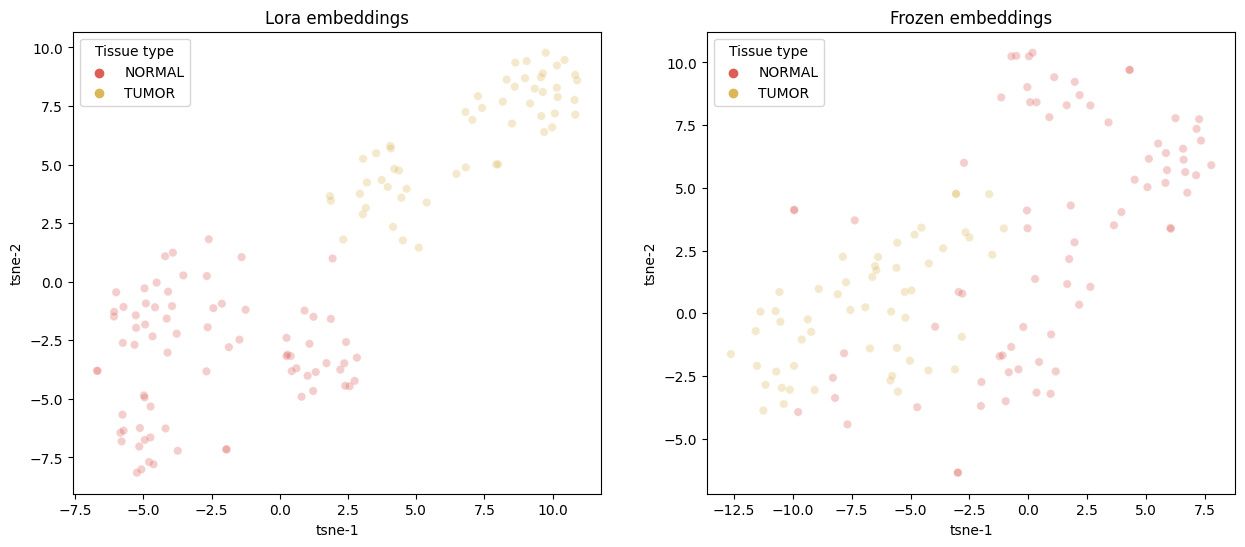

In [34]:
print("Plotting in 2 dimensions.")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0] = plot_tsne_embeddings(
    tsne_embeddings_lora, title="Lora embeddings", ax=axes[0]
)
axes[1] = plot_tsne_embeddings(
    tsne_embeddings_frozen, title="Frozen embeddings", ax=axes[1]
)
plt.show()

In [7]:
# will contain datasets and models
model_directory = Path("/kaggle/input/model-phikon-fined/phikon-finetuned-breast/checkpoint-130")

files = os.listdir(model_directory)
files

['adapter_model.safetensors',
 'trainer_state.json',
 'preprocessor_config.json',
 'training_args.bin',
 'adapter_config.json',
 'README.md',
 'scheduler.pt',
 'optimizer.pt',
 'rng_state.pth']

In [20]:
from peft import PeftModel

model_ft = PeftModel.from_pretrained(
    frozen_model,
    model_directory
)
# Alternative: spécifier explicitement le device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_ft = model_ft.to(device)

In [21]:
subset_size = 130
test_subset = test_dataset[:subset_size]

frozen_model = frozen_model.to("cuda")
print(f"Computing LORA and frozen models embeddings on {subset_size} test images...")
test_subset_embeddings_lora = get_raw_embeddings(
    model=model_ft, dataset=test_subset
)
test_subset_embeddings_frozen = get_raw_embeddings(
    model=frozen_model, dataset=test_subset
)
test_subset_labels = np.array(test_subset["label"])

print("Computing tsne projections...")
tsne_embeddings_lora = get_tsne_embeddings(
    test_subset_embeddings_lora, n_components=2
)
tsne_embeddings_frozen = get_tsne_embeddings(
    test_subset_embeddings_frozen, n_components=2
  )

Computing LORA and frozen models embeddings on 130 test images...


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

Computing tsne projections...


Plotting in 2 dimensions.


<ipython-input-17-b0f7a3590f23>:40: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.scatterplot(
<ipython-input-17-b0f7a3590f23>:40: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.scatterplot(


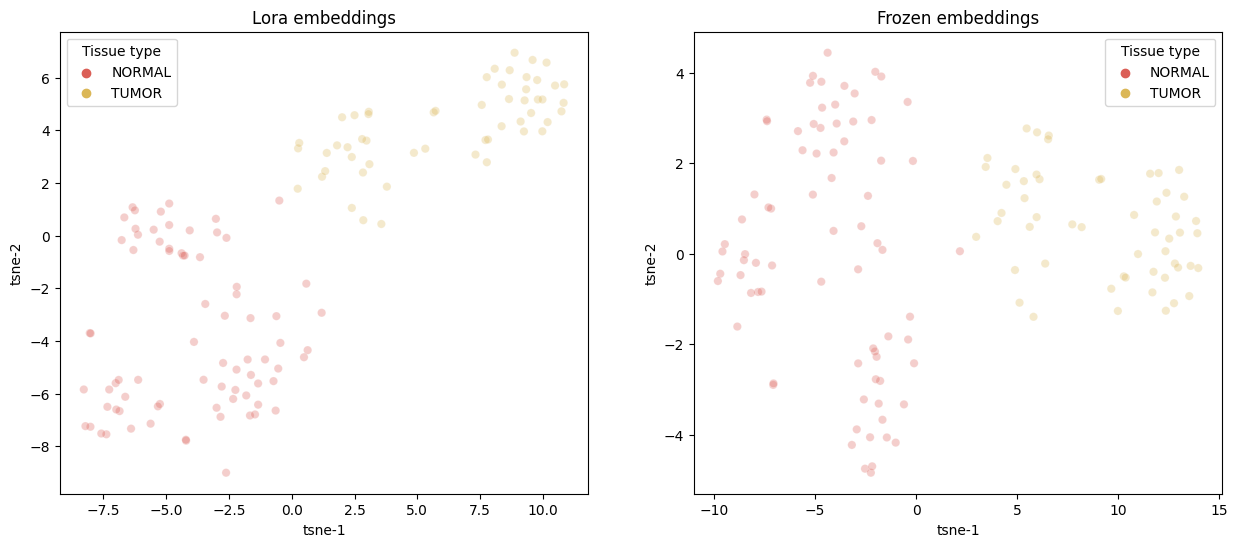

In [24]:
print("Plotting in 2 dimensions.")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0] = plot_tsne_embeddings(
    tsne_embeddings_lora, title="Lora embeddings", ax=axes[0]
)
axes[1] = plot_tsne_embeddings(
    tsne_embeddings_frozen, title="Frozen embeddings", ax=axes[1]
)
plt.show()

In [27]:
from PIL import Image
def predict_class(image_path, model, processor, class_names):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    # Si le modèle renvoie des logits (scores non normalisés)
    if hasattr(outputs, 'logits'):
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class_idx = probabilities.argmax(dim=1).item()
        predicted_class = class_names[predicted_class_idx]
        confidence = probabilities[0, predicted_class_idx].item()
        
        return predicted_class, confidence

In [26]:
predicted_class, confidence = predict_class(testing_directory, model_ft, image_processor, label2id)

NameError: name 'Image' is not defined

In [31]:
image_processor

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [82]:

test_predict_ds = load_dataset(
    path=f"{testing_directory}",
    split="train"
)
test_predict_ds['train']

Resolving data files:   0%|          | 0/139 [00:00<?, ?it/s]

KeyError: "Column train not in the dataset. Current columns in the dataset: ['image', 'label']"

In [71]:
# Chargement d'une image
#image = f"{testing_directory}/new/tumor/tile_02100_c445_r1_c3.png"
#image = Image.open(image_path).convert("RGB")


#image = test_dataset[1]["pixel_values"]
# Prétraitement de l'image
inputs = image_processor(images=test_predict_ds[:]['image'], return_tensors="pt").to(model_ft.device) #, return_tensors="pt"

# Extraction des caractéristiques
with torch.no_grad():
    outputs = model_ft(**inputs, output_hidden_states=True)
    
# Récupérer l'embedding CLS (utile pour la classification)
embedding = outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy()

In [105]:
path_image = f"{testing_directory}"
tumor_predict_ds = load_dataset(
    path=f"{path_image}/tumor",
    split="train"
)
normal_predict_ds = load_dataset(
    path=f"{path_image}/normal",
    split="train"
)
#resultat = pd.DataFrame(columns = ['class', 'y_true', 'proba', 'y_predict','confidence', 'predicted_class'])
resultat = []
for image in tumor_predict_ds[:]['image']:
    inputs = image_processor(images=image, return_tensors="pt").to(model_ft.device)
    with torch.no_grad():
        outputs = model_ft(**inputs, output_hidden_states=True)
    
    # Récupérer l'embedding CLS (utile pour la classification)
    #embedding = outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy()
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_class_idx = probabilities.argmax(dim=1).item()
    confidence = probabilities[0, predicted_class_idx].item()
    predicted_class = label2id[str(predicted_class_idx)]

    resultat.append(["tumor", 1, str(probabilities), predicted_class_idx, confidence, predicted_class])


for image in normal_predict_ds[:]['image']:
    inputs = image_processor(images=image, return_tensors="pt").to(model_ft.device)
    with torch.no_grad():
        outputs = model_ft(**inputs, output_hidden_states=True)
    
    # Récupérer l'embedding CLS (utile pour la classification)
    #embedding = outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy()
    probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_class_idx = probabilities.argmax(dim=1).item()
    confidence = probabilities[0, predicted_class_idx].item()
    predicted_class = label2id[str(predicted_class_idx)]
    #resultat = resultat.append({'class' : "tumor",'y_true' : 0, 'proba' : str(probabilities), 'y_predict': predicted_class_idx, 'confidence' : confidence, 'predicted_class' : predicted_class})
    resultat.append(["normal", 0, str(probabilities), predicted_class_idx, confidence, predicted_class])
    
    

Resolving data files:   0%|          | 0/63 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/76 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [117]:
df = pd.DataFrame(resultat)
df.rename(columns={0 : 'class', 1:'y_true', 2:'proba', 3:'y_predict',4:'confidence', 5:'predicted_class'},inplace = True)
df['loss'] = df['y_true'] - df['y_predict']
df[df['loss'] != 0]

,class,y_true,proba,y_predict,confidence,predicted_class,loss
16,tumor,1,"tensor([[0.7211, 0.2789]], device='cuda:0')",0,0.721052,NORMAL,1
17,tumor,1,"tensor([[0.9125, 0.0875]], device='cuda:0')",0,0.912516,NORMAL,1
18,tumor,1,"tensor([[0.7926, 0.2074]], device='cuda:0')",0,0.792644,NORMAL,1
23,tumor,1,"tensor([[0.9982, 0.0018]], device='cuda:0')",0,0.998193,NORMAL,1
24,tumor,1,"tensor([[0.8368, 0.1632]], device='cuda:0')",0,0.836797,NORMAL,1
25,tumor,1,"tensor([[0.6842, 0.3158]], device='cuda:0')",0,0.684166,NORMAL,1
49,tumor,1,"tensor([[0.8401, 0.1599]], device='cuda:0')",0,0.840098,NORMAL,1
80,normal,0,"tensor([[0.1272, 0.8728]], device='cuda:0')",1,0.872752,TUMOR,-1


In [142]:
recall_score(df['y_true'], df['y_predict']), precision_score(df['y_true'], df['y_predict']), f1_score(df['y_true'], df['y_predict'])

(0.8888888888888888, 0.9824561403508771, 0.9333333333333333)

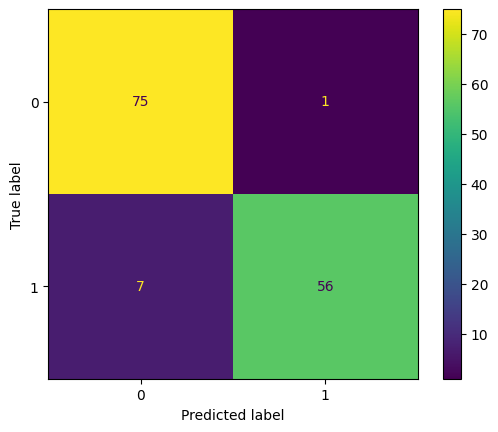

In [139]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
class_ = ['normal','tumor']
confmatr = confusion_matrix(df['y_true'], df['y_predict'])
disp= ConfusionMatrixDisplay(confmatr)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

In [67]:
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class_idx = probabilities.argmax(dim=1).item()
probabilities, predicted_class_idx

(tensor([[1.0000e+00, 4.3132e-06]], device='cuda:0'), 0)

In [97]:
probabilities = torch.softmax(outputs.logits, dim=1)
predicted_class_idx = probabilities.argmax(dim=1).item()
confidence = probabilities[0, predicted_class_idx].item()
predicted_class = label2id[str(predicted_class_idx)]

probabilities, predicted_class_idx, confidence, predicted_class


(tensor([[9.9990e-01, 1.0234e-04]], device='cuda:0'),
 0,
 0.9998975992202759,
 'NORMAL')